# MLP Experiments on muvr data

First we need to setup the environment and import all the necessary stuff.

In [1]:
%matplotlib inline

import logging

logging.basicConfig(level=10)
logger = logging.getLogger()

import shutil
from os import remove
import cPickle as pkl
from os.path import expanduser, exists

This time we are not going to generate the data but rather use real world annotated training examples.

In [34]:
# Dataset creation

import numpy as np
import math
import random
import csv
from neon.datasets.dataset import Dataset

root_path = expanduser('~/data/ca-su-activity')
#root_path = expanduser('~/data/ca-su-activity')
class WorkoutDS(Dataset):
    # Number of features per example
    feature_count = None

    # Number of examples
    num_train_examples = None
    num_test_examples = None

    # Number of classes
    num_labels = None
    
    # Indicator if the data has been loaded yet
    initialized = False
    
    # Mapping of integer class labels to strings
    human_labels = {}
    
    def human_label_for(self, id):
        return self.human_labels[id]
    
    # Convert an integer representation to a one-hot-vector
    def as_one_hot(self, i, n):
        v = np.zeros(n)
        v[i] = 1
        return v
    
    # Convert an one-hot-vector to an integer representation
    def as_int_rep(self, oh):
        return np.where(oh == 1)[0][0]
    
    # Loads a label mapping from file. The file should contain a CSV tabel mapping integer labels to human readable
    # labels. Integer class labels should start with 1
    def load_label_mapping(self, filename):
        with open(expanduser(filename), 'rb') as csvfile:
            dialect = csv.Sniffer().sniff(csvfile.read(1024))
            csvfile.seek(0)
            csv_data = csv.reader(csvfile, dialect)
            next(csv_data, None)  # skip the headers
            label_mapping = {}
            for row in csv_data:
                # We need to offset the labels by one since counting starts at 0 in python...
                label_mapping[int(row[0]) - 1] = row[1]
        return label_mapping
                
    # Load examples from given CSV file. The dataset should already be splitted into test and train externally
    def load_examples(self, filename):
        with open(expanduser(filename), 'rb') as csvfile:
            dialect = csv.Sniffer().sniff(csvfile.read(1024))
            csvfile.seek(0)
            csv_data = csv.reader(csvfile, dialect)
            next(csv_data, None)  # skip the headers
            y = []
            X = []
            for row in csv_data:
                label = int(row[0]) - 1
                y.append(self.as_one_hot(label, self.num_labels))
                X.append(map(lambda x: float(x)*2-1, row[1:]))
                
            X = np.reshape(np.asarray(X, dtype = float), (len(X), len(X[0])))  
            y = np.reshape(np.asarray(y, dtype = float), (X.shape[0], self.num_labels))
            
            return X,y
    
    # Load label mapping and train / test data from disk.
    def initialize(self):
        logger.info("Loading DS from files...")
        self.human_labels = self.load_label_mapping(root_path+'/labeled_exercise_data_f400_LABELS.csv')
        self.num_labels = len(self.human_labels)
        
        X_train, y_train = self.load_examples(root_path+'/labeled_exercise_data_f400_TRAIN.csv')
        X_test, y_test = self.load_examples(root_path+'/labeled_exercise_data_f400_TEST.csv')
        
        self.num_train_examples = X_train.shape[0]
        self.num_test_examples = X_test.shape[0]
        self.feature_count = X_train.shape[1]
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.initialized = True

    # Get the dataset ready for Neon training
    def load(self, **kwargs):
        if not self.initialized:
            self.initialize()

        # Assign training and test datasets
        # INFO: This assumes the data is already shuffeled! Make sure it is!
        self.inputs['train'] = self.X_train
        self.targets['train'] = self.y_train

        self.inputs['test'] =  self.X_test
        self.targets['test'] = self.y_test

        self.format()
        
dataset = WorkoutDS()
dataset.initialize()
print "Number of training examples:", dataset.num_train_examples
print "Number of test examples:", dataset.num_test_examples
print "Number of features:", dataset.feature_count
print "Number of labels:", dataset.num_labels

Number of training examples: 11913
Number of test examples: 3926
Number of features: 1200
Number of labels: 2


At first we want to inspect the class distribution of the training and test examples.

In [36]:
from ipy_table import *
from operator import itemgetter

train_dist = np.reshape(np.transpose(np.sum(dataset.y_train, axis=0)), (dataset.num_labels,1))
test_dist = np.reshape(np.transpose(np.sum(dataset.y_test, axis=0)), (dataset.num_labels,1))

train_ratio = train_dist / dataset.num_train_examples
test_ratio = test_dist / dataset.num_test_examples

# Fiddle around to get it into table shape
table = np.hstack((np.zeros((dataset.num_labels,1), dtype=int), train_dist, train_ratio, test_dist, test_ratio))
table = np.vstack((np.zeros((1, 5), dtype=int), table)).tolist()

human_labels = map(dataset.human_label_for, range(0,dataset.num_labels))

for i,s in enumerate(human_labels):
    table[i + 1][0] = s
    
table.sort(lambda x,y: cmp(x[1], y[1]))

table[0][0] = ""
table[0][1] = "Train"
table[0][2] = "Train %"
table[0][3] = "Test"
table[0][4] = "Test %"

make_table(table)
set_global_style(float_format='%0.0f', align="center")
set_column_style(2, float_format='%0.2f%%')
set_column_style(4, float_format='%0.2f%%')
set_column_style(0, align="left")

,Train,Train %,Test,Test %
exercise,4652,0.39%,1160,0.30%
slacking,7261,0.61%,2766,0.70%


Let's have a look at the generated data. We will plot some of the examples of the different classes.

Ids of plotted examples: [11201  2713 10282]


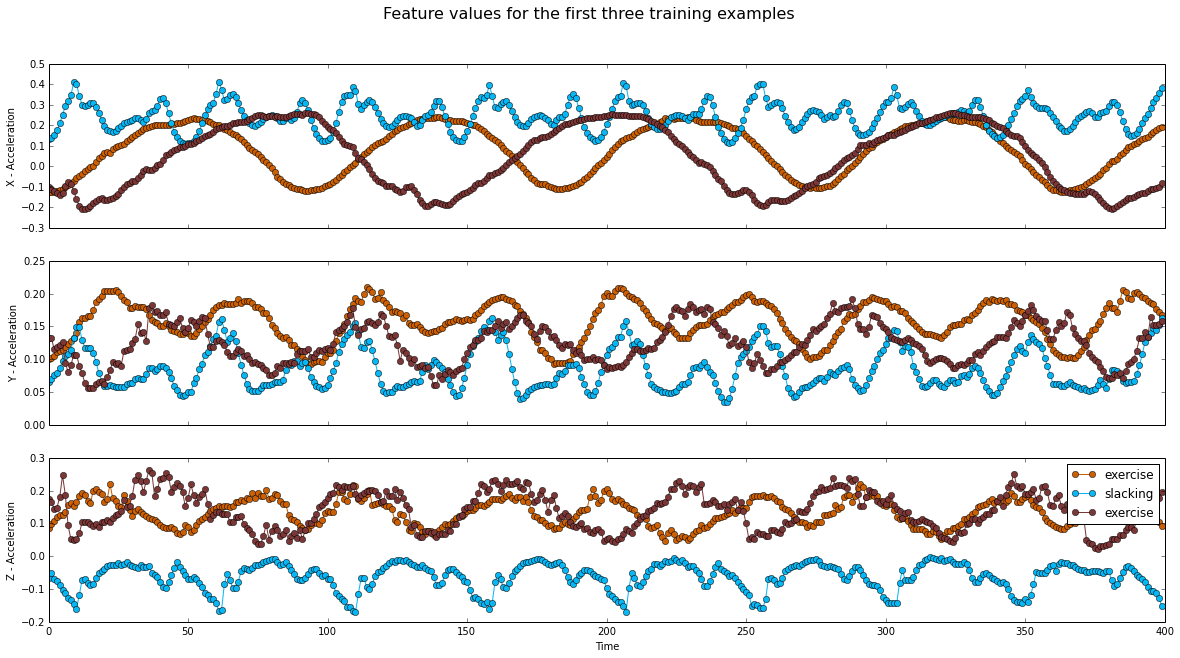

In [37]:
from matplotlib import pyplot, cm
from pylab import *

# Choose some random examples to plot from the training data
number_of_examples_to_plot = 3
plot_ids = np.random.random_integers(0, dataset.num_train_examples - 1, number_of_examples_to_plot)

print "Ids of plotted examples:",plot_ids

# Retrieve a human readable label given the idx of an example
def label_of_example(i):
    label_id = np.where(dataset.y_train[i] == 1)[0][0]
    return dataset.human_label_for(label_id)

figure(figsize=(20,10))
ax1 = subplot(311)
setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('X - Acceleration')

ax2 = subplot(312, sharex=ax1)
setp(ax2.get_xticklabels(), visible=False)
ax2.set_ylabel('Y - Acceleration')

ax3 = subplot(313, sharex=ax1)
ax3.set_ylabel('Z - Acceleration')

for i in plot_ids:
    c = np.random.random((3,))

    ax1.plot(range(0, dataset.feature_count / 3), dataset.X_train[i,0:400], '-o', c=c)
    ax2.plot(range(0, dataset.feature_count / 3), dataset.X_train[i,400:800], '-o', c=c)
    ax3.plot(range(0, dataset.feature_count / 3), dataset.X_train[i,800:1200], '-o', c=c)
    
legend(map(label_of_example, plot_ids))
suptitle('Feature values for the first three training examples', fontsize=16)
xlabel('Time')
show()

Now we are going to create a neon model. We will start with a realy simple one layer preceptron having 500 hidden units.

In [38]:
from neon.backends import gen_backend
from neon.layers import FCLayer, DataLayer, CostLayer, DropOutLayer 
from neon.models import MLP
from neon.transforms import RectLin, Tanh, Logistic, CrossEntropy
from neon.experiments import FitPredictErrorExperiment
from neon.params import val_init
from neon.util.persist import serialize
import time

# General settings
max_epochs = 50
epoch_step_size = 5
batch_size = 30 # max(10, min(100, dataset.num_train_examples/10))
random_seed = 42 # Take your lucky number


# Storage director of the model and its snapshots
file_path = root_path + '/workout-mlp.prm'
if exists(file_path):
    remove(file_path)

# Captured errors for the different epochs
train_err = []
test_err = []

print 'Epochs: %d Batch-Size: %d' % (max_epochs, batch_size)

# Generate layers and a MLP model using the given settings
def model_gen(lrate, momentum_coef, num_epochs, batch_size):
    layers = []

    layers.append(DataLayer(nout=dataset.feature_count))

    layers.append(FCLayer(
            name="fc_1",
            nout=50, 
            lrule_init={'lr_params': {'learning_rate': lrate,
                'momentum_params': {'coef': momentum_coef, 'type': 'constant'}},
                'type': 'gradient_descent_momentum'},
            weight_init=val_init.UniformValGen(low=-0.1,high=0.1, bias_init=1.0),
            activation=RectLin()
        )
    )
    
    layers.append(DropOutLayer(
            name="do_1",
            keep = 0.9
        )
    )
    
    layers.append(FCLayer(
            name="fc_2",
            nout=25,
            lrule_init={'lr_params': {'learning_rate': lrate,
                'momentum_params': {'coef': momentum_coef, 'type': 'constant'}},
                'type': 'gradient_descent_momentum'},
            weight_init=val_init.UniformValGen(low=-0.1,high=0.1, bias_init=1.0),
            activation=RectLin()
        )
    )
    
    layers.append(DropOutLayer(
            name="do_3",
            keep = 0.9
        )
    )
    
    layers.append(FCLayer(
            name="fc_4",
            nout = dataset.num_labels,
            lrule_init={'lr_params': {'learning_rate': lrate,
                'momentum_params': {'coef': momentum_coef, 'type': 'constant'}},
                'type': 'gradient_descent_momentum'},
            weight_init=val_init.UniformValGen(low=-0.1,high=0.1, bias_init=1.0),
            activation = Logistic()
        )
    )

    layers.append(CostLayer(
            name = 'cost',
            ref_layer = layers[0],
            cost = CrossEntropy()
        )
    )
    model = MLP(num_epochs=num_epochs, batch_size=batch_size, layers=layers, serialized_path=file_path)
    return model

# Set logging output...
for name in ["neon.util.persist", "neon.datasets.dataset", "neon.models.mlp"]:
    dslogger = logging.getLogger(name)
    dslogger.setLevel(20)

print "Starting training..."
start = time.time()
for num_epochs in range(0,max_epochs+1, epoch_step_size):

    if num_epochs > 230:
        lrate = 0.0000003
    elif num_epochs > 180:
        lrate = 0.000001
    elif num_epochs > 500:
        lrate = 0.0003
    else:
        lrate = 0.001
    
    # set up the model and experiment
    model = model_gen(lrate = lrate, 
                      momentum_coef = 0.9, 
                      num_epochs = num_epochs, 
                      batch_size = batch_size)
    
    # Uncomment line below to run on CPU backend
    backend = gen_backend(rng_seed=random_seed)
    # Uncomment line below to run on GPU using cudanet backend
    # backend = gen_backend(rng_seed=0, gpu='cudanet')
    experiment = FitPredictErrorExperiment(model=model,
                                           backend=backend,
                                           dataset=dataset)

    # Run the training, and dump weights
    dest_path = root_path+'/workout-ep' + str(num_epochs) + '.prm'
    if num_epochs > 0:
        res = experiment.run()
        train_err.append(res['train']['MisclassPercentage_TOP_1'])
        test_err.append(res['test']['MisclassPercentage_TOP_1'])
        # Save the weights at this epoch
        shutil.copy2(file_path, dest_path)
        print "Finished epoch " + str(num_epochs)
    else:
        model.epochs_complete = 0
        serialize(model.get_params(), dest_path)

print "Finished training!"
end = time.time()
print "Duration", end - start, "seconds"


INFO:neon.models.mlp:Layers:
	DataLayer layer: 1200 nodes
	FCLayer fc_1: 1200 inputs, 50 nodes, RectLin act_fn
	DropOutLayer do_1: 50 inputs, 50 nodes, Linear act_fn
	FCLayer fc_2: 50 inputs, 25 nodes, RectLin act_fn
	DropOutLayer do_3: 25 inputs, 25 nodes, Linear act_fn
	FCLayer fc_4: 25 inputs, 2 nodes, Logistic act_fn
	CostLayer cost: 2 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:Layers:
	DataLayer layer: 1200 nodes
	FCLayer fc_1: 1200 inputs, 50 nodes, RectLin act_fn
	DropOutLayer do_1: 50 inputs, 50 nodes, Linear act_fn
	FCLayer fc_2: 50 inputs, 25 nodes, RectLin act_fn
	DropOutLayer do_3: 25 inputs, 25 nodes, Linear act_fn
	FCLayer fc_4: 25 inputs, 2 nodes, Logistic act_fn
	CostLayer cost: 2 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 1, training error: 1.15986
INFO:neon.models.mlp:epoch: 2, training error: 0.81976
INFO:neon.models.mlp:epoch: 3, training error: 0.72349
INFO:neon.models.mlp:epoch: 4, training error: 

Epochs: 50 Batch-Size: 30
Starting training...
Finished epoch 5

INFO:neon.models.mlp:Layers:
	DataLayer layer: 1200 nodes
	FCLayer fc_1: 1200 inputs, 50 nodes, RectLin act_fn
	DropOutLayer do_1: 50 inputs, 50 nodes, Linear act_fn
	FCLayer fc_2: 50 inputs, 25 nodes, RectLin act_fn
	DropOutLayer do_3: 25 inputs, 25 nodes, Linear act_fn
	FCLayer fc_4: 25 inputs, 2 nodes, Logistic act_fn
	CostLayer cost: 2 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 6, training error: 0.44488
INFO:neon.models.mlp:epoch: 7, training error: 0.36738
INFO:neon.models.mlp:epoch: 8, training error: 0.30867
INFO:neon.models.mlp:epoch: 9, training error: 0.26612
INFO:neon.models.mlp:epoch: 10, training error: 0.23856



Finished epoch 10

INFO:neon.models.mlp:Layers:
	DataLayer layer: 1200 nodes
	FCLayer fc_1: 1200 inputs, 50 nodes, RectLin act_fn
	DropOutLayer do_1: 50 inputs, 50 nodes, Linear act_fn
	FCLayer fc_2: 50 inputs, 25 nodes, RectLin act_fn
	DropOutLayer do_3: 25 inputs, 25 nodes, Linear act_fn
	FCLayer fc_4: 25 inputs, 2 nodes, Logistic act_fn
	CostLayer cost: 2 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 11, training error: 0.20859
INFO:neon.models.mlp:epoch: 12, training error: 0.18013
INFO:neon.models.mlp:epoch: 13, training error: 0.16185
INFO:neon.models.mlp:epoch: 14, training error: 0.14765
INFO:neon.models.mlp:epoch: 15, training error: 0.13593



Finished epoch 15

INFO:neon.models.mlp:Layers:
	DataLayer layer: 1200 nodes
	FCLayer fc_1: 1200 inputs, 50 nodes, RectLin act_fn
	DropOutLayer do_1: 50 inputs, 50 nodes, Linear act_fn
	FCLayer fc_2: 50 inputs, 25 nodes, RectLin act_fn
	DropOutLayer do_3: 25 inputs, 25 nodes, Linear act_fn
	FCLayer fc_4: 25 inputs, 2 nodes, Logistic act_fn
	CostLayer cost: 2 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 16, training error: 0.12406
INFO:neon.models.mlp:epoch: 17, training error: 0.11017
INFO:neon.models.mlp:epoch: 18, training error: 0.10415
INFO:neon.models.mlp:epoch: 19, training error: 0.09924
INFO:neon.models.mlp:epoch: 20, training error: 0.09383



Finished epoch 20

INFO:neon.models.mlp:Layers:
	DataLayer layer: 1200 nodes
	FCLayer fc_1: 1200 inputs, 50 nodes, RectLin act_fn
	DropOutLayer do_1: 50 inputs, 50 nodes, Linear act_fn
	FCLayer fc_2: 50 inputs, 25 nodes, RectLin act_fn
	DropOutLayer do_3: 25 inputs, 25 nodes, Linear act_fn
	FCLayer fc_4: 25 inputs, 2 nodes, Logistic act_fn
	CostLayer cost: 2 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 21, training error: 0.08673
INFO:neon.models.mlp:epoch: 22, training error: 0.07870
INFO:neon.models.mlp:epoch: 23, training error: 0.07653
INFO:neon.models.mlp:epoch: 24, training error: 0.07457
INFO:neon.models.mlp:epoch: 25, training error: 0.07256



Finished epoch 25

INFO:neon.models.mlp:Layers:
	DataLayer layer: 1200 nodes
	FCLayer fc_1: 1200 inputs, 50 nodes, RectLin act_fn
	DropOutLayer do_1: 50 inputs, 50 nodes, Linear act_fn
	FCLayer fc_2: 50 inputs, 25 nodes, RectLin act_fn
	DropOutLayer do_3: 25 inputs, 25 nodes, Linear act_fn
	FCLayer fc_4: 25 inputs, 2 nodes, Logistic act_fn
	CostLayer cost: 2 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 26, training error: 0.06694
INFO:neon.models.mlp:epoch: 27, training error: 0.06160
INFO:neon.models.mlp:epoch: 28, training error: 0.06070
INFO:neon.models.mlp:epoch: 29, training error: 0.05977
INFO:neon.models.mlp:epoch: 30, training error: 0.05935



Finished epoch 30

INFO:neon.models.mlp:Layers:
	DataLayer layer: 1200 nodes
	FCLayer fc_1: 1200 inputs, 50 nodes, RectLin act_fn
	DropOutLayer do_1: 50 inputs, 50 nodes, Linear act_fn
	FCLayer fc_2: 50 inputs, 25 nodes, RectLin act_fn
	DropOutLayer do_3: 25 inputs, 25 nodes, Linear act_fn
	FCLayer fc_4: 25 inputs, 2 nodes, Logistic act_fn
	CostLayer cost: 2 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 31, training error: 0.05438
INFO:neon.models.mlp:epoch: 32, training error: 0.05027
INFO:neon.models.mlp:epoch: 33, training error: 0.04992
INFO:neon.models.mlp:epoch: 34, training error: 0.04930
INFO:neon.models.mlp:epoch: 35, training error: 0.04981



Finished epoch 35

INFO:neon.models.mlp:Layers:
	DataLayer layer: 1200 nodes
	FCLayer fc_1: 1200 inputs, 50 nodes, RectLin act_fn
	DropOutLayer do_1: 50 inputs, 50 nodes, Linear act_fn
	FCLayer fc_2: 50 inputs, 25 nodes, RectLin act_fn
	DropOutLayer do_3: 25 inputs, 25 nodes, Linear act_fn
	FCLayer fc_4: 25 inputs, 2 nodes, Logistic act_fn
	CostLayer cost: 2 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 36, training error: 0.04522
INFO:neon.models.mlp:epoch: 37, training error: 0.04187
INFO:neon.models.mlp:epoch: 38, training error: 0.04202
INFO:neon.models.mlp:epoch: 39, training error: 0.04158
INFO:neon.models.mlp:epoch: 40, training error: 0.04230



Finished epoch 40

INFO:neon.models.mlp:Layers:
	DataLayer layer: 1200 nodes
	FCLayer fc_1: 1200 inputs, 50 nodes, RectLin act_fn
	DropOutLayer do_1: 50 inputs, 50 nodes, Linear act_fn
	FCLayer fc_2: 50 inputs, 25 nodes, RectLin act_fn
	DropOutLayer do_3: 25 inputs, 25 nodes, Linear act_fn
	FCLayer fc_4: 25 inputs, 2 nodes, Logistic act_fn
	CostLayer cost: 2 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 41, training error: 0.03826
INFO:neon.models.mlp:epoch: 42, training error: 0.03531
INFO:neon.models.mlp:epoch: 43, training error: 0.03561
INFO:neon.models.mlp:epoch: 44, training error: 0.03522
INFO:neon.models.mlp:epoch: 45, training error: 0.03652



Finished epoch 45

INFO:neon.models.mlp:Layers:
	DataLayer layer: 1200 nodes
	FCLayer fc_1: 1200 inputs, 50 nodes, RectLin act_fn
	DropOutLayer do_1: 50 inputs, 50 nodes, Linear act_fn
	FCLayer fc_2: 50 inputs, 25 nodes, RectLin act_fn
	DropOutLayer do_3: 25 inputs, 25 nodes, Linear act_fn
	FCLayer fc_4: 25 inputs, 2 nodes, Logistic act_fn
	CostLayer cost: 2 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 46, training error: 0.03286
INFO:neon.models.mlp:epoch: 47, training error: 0.03024
INFO:neon.models.mlp:epoch: 48, training error: 0.03061
INFO:neon.models.mlp:epoch: 49, training error: 0.03034
INFO:neon.models.mlp:epoch: 50, training error: 0.03183



Finished epoch 50
Finished training!
Duration 18.9683389664 seconds


To check weather the network is learning something we will plot the weight matrices of the different training epochs.

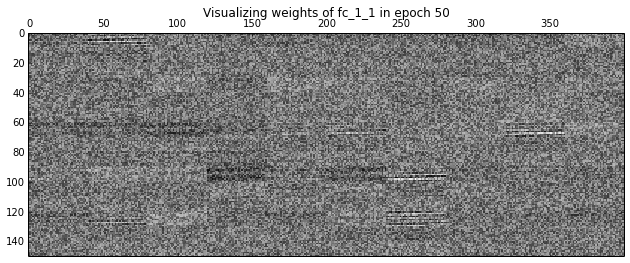

In [39]:
import numpy as np
import math
from matplotlib import pyplot, cm
from pylab import *
from IPython.html import widgets
from IPython.html.widgets import interact

def closestSqrt(i):
    N = int(math.sqrt(i))
    while True:
        M = int(i / N)
        if N * M == i:
            return N, M
        N -= 1
        
def plot_filters(**kwargs):
    n = kwargs['n']
    layer_name = kwargs['layer']
    dest_path = root_path+'/workout-ep' + str(n) + '.prm'
    params = pkl.load(open(dest_path, 'r'))

    wts = params[layer_name]['weights']

    nrows, ncols = closestSqrt(wts.shape[0])
    fr, fc = closestSqrt(wts.shape[1])
    
    fi = 0

    W = np.zeros((fr*nrows, fc*ncols))
    for row, col in [(row, col) for row in range(nrows) for col in range(ncols)]:
        W[fr*row:fr*(row+1):,fc*col:fc*(col+1)] = wts[fi].reshape(fr,fc)
        fi = fi + 1

    matshow(W, cmap=cm.gray)
    title('Visualizing weights of '+layer_name+' in epoch ' + str(n) )
    show()
    
layer_names = map(lambda l: l[1].name+"_"+str(l[0]), filter(lambda l: l[1].has_params, enumerate(model.layers)))

_i = interact(plot_filters,
              layer=widgets.widget_selection.ToggleButtons(options = layer_names),
              n=widgets.IntSliderWidget(description='epochs',
                                        min=0, max=max_epochs, value=0, step=epoch_step_size))



Store the layer weights in a packed raw file. The layers need to be put into the file in the same order as they appear in the network.

In [40]:
import numpy as np
import struct

def layer_names(params):
    layer_names = params.keys()
    layer_names.remove('epochs_complete')
    # Sort layers by their appearance in the model architecture
    # Since neon appands the index to the layer name we will use it to sort
    layer_names.sort(key=lambda x: int(x.split("_")[-1]))
    return layer_names

def getweights(file_name):
    vec = []
    # Load a stored model file from disk (should have extension prm)
    params = pkl.load(open(file_name, 'r'))
    layers = layer_names(params)

    for layer in layers:
        # Make sure our model has biases activated, otherwise add zeros here
        b = params[layer]['biases']
        w = params[layer]['weights']

        newvec = np.ravel(np.hstack((b,w)))
        [vec.append(nv) for nv in newvec]
    return vec

weights = getweights(root_path+'/workout-mlp.prm')
f = open(root_path+"/weights.raw","wb")

#  You can use 'd' for double and < or > to force endinness
bin_data=struct.pack('d'*len(weights), *weights)

f.write(bin_data)
f.close()


Store the labels in a file so we are able to decode the labels the MLP produces into human readable strings. They need to be in index ascending order.

In [41]:
import collections

labels = collections.OrderedDict(sorted(dataset.human_labels.items())).values()

f = open(root_path+"/labels.txt","wb")

for label in labels:
  f.write("%s\n" % label)
f.close()

Let's visualize the error to see if the network has trained properly or if we are overfitting.

Lowest test error: 1.79%
Lowest train error: 0.03%


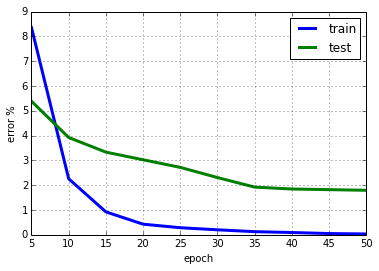

In [42]:
print "Lowest test error: %0.2f%%" % np.min(test_err)
print "Lowest train error: %0.2f%%" % np.min(train_err)

pyplot.plot(range(epoch_step_size, max_epochs+1, epoch_step_size), train_err, linewidth=3, label='train')
pyplot.plot(range(epoch_step_size, max_epochs+1, epoch_step_size), test_err, linewidth=3, label='test')
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("error %")
pyplot.show()

Let's also have a look at the confusion matrix for the test dataset.

In [43]:
from sklearn.metrics import confusion_matrix
from ipy_table import *

# confusion_matrix(y_true, y_pred)
predicted, actual = model.predict_fullset(dataset, "test")

y_pred = np.argmax(predicted.asnumpyarray(), axis = 0) 
y_true = np.argmax(actual.asnumpyarray(), axis = 0) 

confusion_mat = confusion_matrix(y_true, y_pred, range(0,dataset.num_labels))

# Fiddle around with cm to get it into table shape
confusion_mat = vstack((np.zeros((1,dataset.num_labels), dtype=int), confusion_mat))
confusion_mat = hstack((np.zeros((dataset.num_labels + 1, 1), dtype=int), confusion_mat))

table = confusion_mat.tolist()

human_labels = map(dataset.human_label_for, range(0,dataset.num_labels))

for i,s in enumerate(human_labels):
    table[0][i+1] = s
    table[i+1][0] = s

table[0][0] = "actual \ predicted"

mt = make_table(table)
set_row_style(0, color='lightGray', rotate = "315deg")
set_column_style(0, color='lightGray')
set_global_style(align='center')

for i in range(1, dataset.num_labels + 1):
    for j in range(1, dataset.num_labels + 1):
        if i == j:
            set_cell_style(i,j, color='lightGreen', width = 80)
        elif table[i][j] > 20:
            set_cell_style(i,j, color='Pink')
        elif table[i][j] > 0:
            set_cell_style(i,j, color='lightYellow')
mt

actual \ predicted,exercise,slacking
exercise,1142,10
slacking,60,2688
